# Optimization of Fairness–Accuracy Trade-offs in Gradient-Based Classification Models

**Course:** COSC 3P99 – Independent Research Project  
**Student:** David Shodipo  
**Supervisor:** Dr. Blessing Ogbuokiri  
**Term:** Winter 2026  


## Project Overview

Machine learning classification models are commonly trained using gradient-based optimization techniques with the primary goal of maximizing predictive accuracy. However, focusing only on accuracy can cause the model to perform better for some demographic groups than others, which can be unfair and raise ethical concerns.

This project investigates the **trade-off between predictive accuracy and fairness** in gradient-based classification models by introducing fairness-aware regularization during training. The study focuses on how optimization parameters such as learning rate, training duration, and fairness regularization strength influence both accuracy and group fairness metrics.


## Research Questions

This project aims to answer the following questions:

1. How do fairness constraints affect predictive accuracy in gradient-based classifiers?
2. How do optimization parameters influence the fairness–accuracy trade-off?
3. Are fairness effects consistent across different application domains/groups?



## Objectives

- Train baseline accuracy-only classifiers
- Introduce fairness-aware regularization into the loss function
- Measure changes in:
  - Accuracy / AUC
  - Demographic Parity Difference
  - Equal Opportunity Difference
- Visualize and interpret fairness–accuracy trade-offs


## Datasets

Two publicly available datasets are used in this study:

### 1. Healthcare Dataset
- **Dataset:** UCI Heart Disease Dataset
- **Task:** Predict presence of heart disease
- **Sensitive Attribute:** Sex (optional extension: age group)

### 2. Non-Healthcare Dataset
- **Dataset:** UCI Adult Income Dataset
- **Task:** Predict whether income exceeds $50K (Defined of  the dataset Information Provided)
- **Sensitive Attribute:** Sex or Race


In [1]:
# Libraries
%pip install pandas numpy matplotlib seaborn scikit-learn
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Reproducibility
np.random.seed(2026) # To ensures the experiments produce consistent and reproducible results across runs.

# Week 1: Problem Setup and Baseline Models

The goal of Week 1 is to clean and preprocess both datasets and train basic models that focus only on accuracy using standard log loss. These models would act as a benchmark for comparing the effects of adding fairness constraints later in the project.

## Installing the ucimlrepo package

In [3]:
%pip install ucimlrepo
# To fetch datasets from the UCI Machine Learning Repository
from ucimlrepo import fetch_ucirepo


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


## Adult Income dataset

In [4]:
# Adult Income dataset
from pathlib import Path
import pandas as pd

csv_path = Path("adult_income_dataset.csv")
if not csv_path.exists():
    raise FileNotFoundError(
        f"Missing {csv_path}. Expected it in the notebook folder. "
        "If you moved it, update csv_path accordingly."
    )

data = pd.read_csv(csv_path)

# Standardize target column name for downstream cells
if "income" not in data.columns and "class" in data.columns:
    data = data.rename(columns={"class": "income"})

# Extract features and target (kept for consistency with earlier code)
if "income" in data.columns:
    X = data.drop(columns=["income"])
    y = data[["income"]]
else:
    # last-resort fallback
    X = data.iloc[:, :-1]
    y = data.iloc[:, [-1]]

# Print dataframe
display(data.head())
print("Shape:", data.shape)  # show (rows, cols)
display(data.info())

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


Shape: (48790, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48790 entries, 0 to 48789
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48790 non-null  int64 
 1   workclass       45995 non-null  object
 2   fnlwgt          48790 non-null  int64 
 3   education       48790 non-null  object
 4   education-num   48790 non-null  int64 
 5   marital-status  48790 non-null  object
 6   occupation      45985 non-null  object
 7   relationship    48790 non-null  object
 8   race            48790 non-null  object
 9   sex             48790 non-null  object
 10  capital-gain    48790 non-null  int64 
 11  capital-loss    48790 non-null  int64 
 12  hours-per-week  48790 non-null  int64 
 13  native-country  47934 non-null  object
 14  income          48790 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


None

### Handle missing values 
This function tidies string columns, replaces `?` with real missing values, normalizes income labels, and drops duplicate rows so the data is cleaner for modelling.

In [5]:
import pandas as pd
import numpy as np

# Cleaning the data

def clean_adult_df(df: pd.DataFrame) -> pd.DataFrame:
    """
    Clean the Adult Income dataset by standardizing strings,
    handling missing values, fixing label formatting,
    and removing duplicate records.
    """
    # Work on a copy to avoid modifying the original DataFrame
    df = df.copy()

    # Identify all categorical (string) columns
    categorical_cols = df.select_dtypes(include="object").columns

    # Strip leading/trailing whitespace from string columns
    for col in categorical_cols:
        df[col] = df[col].str.strip()

    # Convert Adult dataset's '?' placeholder to proper missing values
    df = df.replace("?", np.nan)

    # Fix income labels in the test set (e.g., '>50K.' -> '>50K')
    if "income" in df.columns:
        df["income"] = df["income"].str.replace(".", "", regex=False)

    # Remove exact duplicate rows
    df = df.drop_duplicates()

    return df


In [6]:
data = clean_adult_df(data)
# Check for missing values
display(data.isnull().sum().sort_values(ascending=False))

# Also print to csv file
data.to_csv('adult_income_dataset.csv', index=False)


occupation        2805
workclass         2795
native-country     856
age                  0
fnlwgt               0
education            0
education-num        0
marital-status       0
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
income               0
dtype: int64

Most missing values appear in a few categorical columns (occupation, workclass, native-country), not across the whole dataset. If you leave them as-is, models that use those columns can lose useful information or learn biased patterns. Because occupation and workclass have many missing entries, dropping rows would remove a sizeable chunk of data and could introduce bias

In [7]:
# summary statistics
summary_stats = data.describe()
summary_stats

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,48790.000000,4.879000e+04,48790.000000,48790.000000,48790.000000,48790.000000
mean,38.652798,1.896690e+05,10.078807,1080.217688,87.595573,40.425886
std,13.708493,1.056172e+05,2.570046,7455.905921,403.209129,12.392729
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175550e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781385e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376062e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


### Define features, target and sensitive attribute for Adult dataset
Builds the model target (0/1) from the income column, keeps features separate, and picks a protected attribute (`sex` or `race`) for fairness analysis.


In [8]:
# Extract target and sensitive attribute names
if 'income' in data.columns:
    target_col = 'income'
else:
    # fall back to last column if naming differs
    target_col = data.columns[-1]

# Map income to binary target
y = (data[target_col].astype(str).str.strip() == ">50K").astype(int)  # 1 for >50K, else 0
X = data.drop(columns=[target_col])

# Choose sensitive attribute (prefer 'sex', else try 'race')
for cand in ['sex', 'race']:
    if cand in X.columns:
        sensitive_attr = cand
        break
else:
    # if none of the common names exist, choose the first categorical column
    cat_cols = X.select_dtypes(include=['object']).columns.tolist()
    sensitive_attr = cat_cols[0] if cat_cols else None

print('Target column:', target_col)
print('Sensitive attribute chosen:', sensitive_attr)

Target column: income
Sensitive attribute chosen: sex


###  Split into training and test sets 
**Note:** Splits the data into training and testing sets while keeping the class distribution the same, saves the sensitive attribute separately for fairness checks, and removes it from the inputs to avoid direct use in the model. If the model still treats groups differently, that difference comes from other information that happens to be linked to those groups 

In [9]:
# Train/test split with stratification to maintain class balance in both sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=2026
)

# Also extract sensitive attribute arrays for later group metrics
A_train = X_train[sensitive_attr].copy() if sensitive_attr is not None else None
A_test = X_test[sensitive_attr].copy() if sensitive_attr is not None else None

# Remove sensitive attribute from features before modeling to prevent direct discrimination
if sensitive_attr is not None:
    X_train = X_train.drop(columns=[sensitive_attr])
    X_test = X_test.drop(columns=[sensitive_attr])

print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)

Train shape: (39032, 13) Test shape: (9758, 13)


### Preprocessing + Baseline Logistic Regression

In [10]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

# Separate numeric and categorical columns
numeric_features = X_train.select_dtypes(include=["int64", "float64"]).columns
categorical_features = X_train.select_dtypes(include=["object"]).columns

# Numeric transformer: fill missing values with median, then scale
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Categorical transformer: fill missing with most frequent, then one-hot encode
categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# Column transformer applies the two transformers to their respective columns
preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)
])

# Full pipeline: preprocessing then logistic regression
baseline_model = Pipeline([
    ("preprocess", preprocessor),
    ("clf", LogisticRegression(max_iter=1000))
])

# Fit baseline model
baseline_model.fit(X_train, y_train)


,steps,"[('preprocess', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [11]:
# One-hot encode is used to convert text categories into numbers so ML models can use them (it does not imply any order).

### Evaluate Accuracy + AUC
Prints simple performance numbers: accuracy (how often the model is right) and AUC (how well it ranks positives vs negatives), plus a full classification report.

In [12]:
y_pred = baseline_model.predict(X_test)
y_prob = baseline_model.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_prob))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.8533510965361755
AUC: 0.9074210833767068

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.94      0.91      7422
           1       0.74      0.59      0.66      2336

    accuracy                           0.85      9758
   macro avg       0.81      0.76      0.78      9758
weighted avg       0.85      0.85      0.85      9758



#### ROC Curve

The ROC curve visualizes the trade-off between true positive rate and false positive rate across classification thresholds. The Area Under the Curve (AUC) summarizes overall discriminative performance.

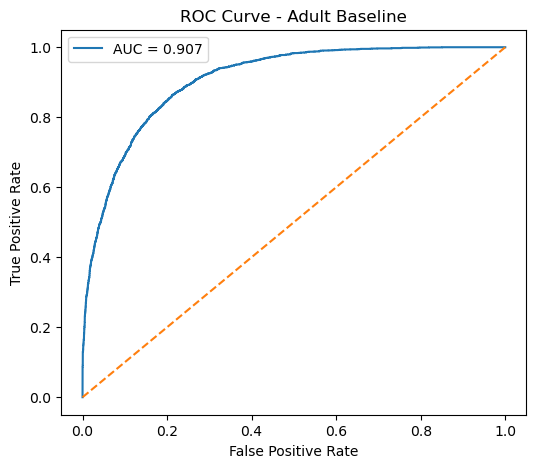

In [13]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob):.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Adult Baseline")
plt.legend()
plt.show()

AUC = 0.907 means the model ranks positives above negatives about 90.7% of the time, so it separates the two classes well. There’s a trade-off: catching more positives raises false alarms, while reducing false alarms misses positives,  we have to choose the threshold based on which error we care about more

#### Confusion Matrix
The confusion matrix provides a breakdown of true positives, false positives, true negatives, and false negatives. This helps interpret group-level fairness metrics such as Equal Opportunity.


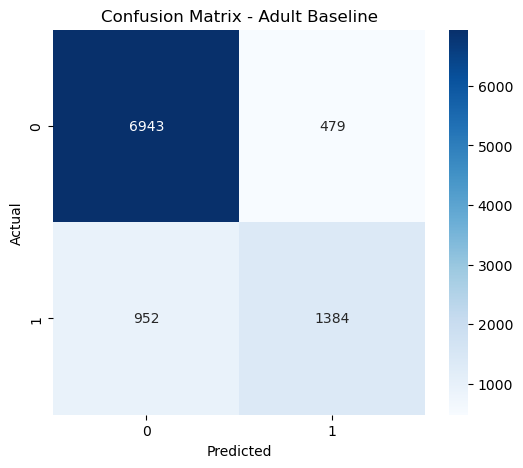

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Adult Baseline")
plt.show()


In [15]:
# The model is conservative about predicting the positive class (predicts fewer positives than there are).
# Predicted positives are fairly reliable (good precision ~74%), but the model misses a substantial share of true positives (recall ~59% — about 41% of positives are missed).
# Depending on whether missing positives or raising false alarms is more costly, WE would adjust the decision threshold or training approach.


The baseline model minimizes standard log loss via gradient-based optimization without fairness constraints. 
Any fairness disparities observed therefore reflect the behavior of accuracy-only optimization, which prioritizes predictive performance over group equity.


## Fairness Metrics for Adult Income Dataset

### Demographic Parity Difference

In [16]:
def demographic_parity_diff(y_pred, A):
    A = pd.Series(A).reset_index(drop=True)
    y_pred = pd.Series(y_pred).reset_index(drop=True)

    rates = {}
    for group in A.unique():
        rates[group] = y_pred[A == group].mean()

    return max(rates.values()) - min(rates.values()), rates


In [17]:

dp_diff, dp_rates = demographic_parity_diff(y_pred, A_test)

print("Demographic Parity Difference:", dp_diff)
print("Positive prediction rates by group:", dp_rates)


Demographic Parity Difference: 0.16612841421188687
Positive prediction rates by group: {'Male': np.float64(0.24531464269389), 'Female': np.float64(0.07918622848200313)}


Shows the DP gap and the per-group rates so you can see which group gets more positive predictions.

#### Demographic Parity Plot

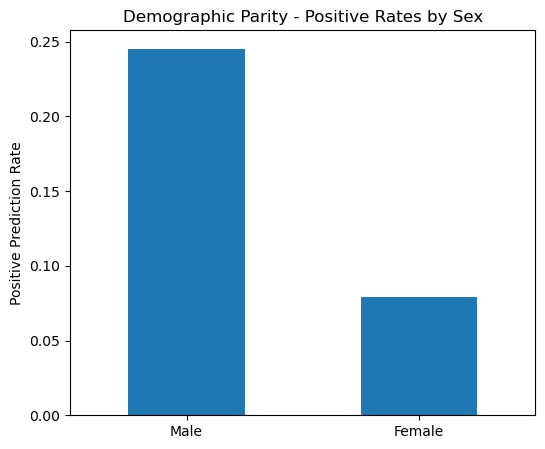

In [18]:
dp_rates_series = pd.Series(dp_rates)

plt.figure(figsize=(6,5))
dp_rates_series.plot(kind="bar")
plt.ylabel("Positive Prediction Rate")
plt.title("Demographic Parity - Positive Rates by Sex")
plt.xticks(rotation=0)
plt.show()


In [19]:
# Big gap = unfair: one group gets more positive predictions than the other.
# Here the gap is 0.15 - the model predicts ">50K" about 15% more often for males than females.
# That means females are less likely to be predicted as high earners.
# If this matters,  we try steps to make predictions more equal between groups.

### Equal Opportunity Difference

In [20]:
def equal_opportunity_diff(y_true, y_pred, A):
    A = pd.Series(A).reset_index(drop=True)
    y_true = pd.Series(y_true).reset_index(drop=True)
    y_pred = pd.Series(y_pred).reset_index(drop=True)

    tprs = {}
    for group in A.unique():
        idx = (A == group)
        positives = (y_true[idx] == 1)
        if positives.sum() > 0:
            tprs[group] = (y_pred[idx][positives] == 1).mean()
        else:
            tprs[group] = np.nan

    return np.nanmax(list(tprs.values())) - np.nanmin(list(tprs.values())), tprs


In [21]:

eo_diff, eo_tprs = equal_opportunity_diff(y_test, y_pred, A_test)

print("Equal Opportunity Difference (TPR Gap):", eo_diff)
print("TPR by group:", eo_tprs)


Equal Opportunity Difference (TPR Gap): 0.07469746091190754
TPR by group: {'Male': np.float64(0.6039453717754173), 'Female': np.float64(0.5292479108635098)}


#### Equal Opportunity Plot

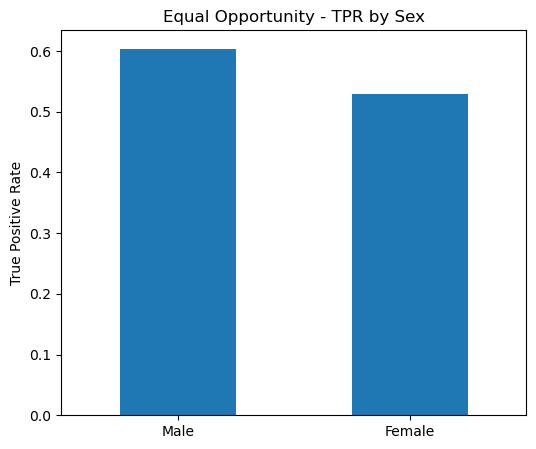

In [22]:
eo_tprs_series = pd.Series(eo_tprs)

plt.figure(figsize=(6,5))
eo_tprs_series.plot(kind="bar")
plt.ylabel("True Positive Rate")
plt.title("Equal Opportunity - TPR by Sex")
plt.xticks(rotation=0)
plt.show()


In [23]:
# Ideally bars should be similar height
# In this case, the equal opportunity difference (TPR gap) is 0.10,
# which indicates that the model has a higher true positive rate for one group (males) compared to the other group (females).

##  Baseline results table for Adult Income dataset

In [24]:
import pandas as pd

results = {
    "dataset": ["Adult Income"],
    "accuracy": [accuracy_score(y_test, y_pred)],
    "auc": [roc_auc_score(y_test, y_prob)],
    "dp_diff": [dp_diff],
    "eo_diff": [eo_diff]
}
results_df = pd.DataFrame(results)
display(results_df)
results_df.to_csv("baseline_results_adult.csv", index=False)

,dataset,accuracy,auc,dp_diff,eo_diff
0,Adult Income,0.853351,0.907421,0.166128,0.074697


## Heart Disease Dataset

In [25]:
# Heart Disease dataset (offline): read from local CSV
from pathlib import Path
import pandas as pd

csv_path_hd = Path("heart_disease_dataset.csv")
if not csv_path_hd.exists():
    raise FileNotFoundError(
        f"Missing {csv_path_hd}. Expected it in the notebook folder. "
        "If you moved it, update csv_path_hd accordingly."
    )

data_hd = pd.read_csv(csv_path_hd)

# Identify target column (usually 'num' in UCI Heart Disease)
if "num" in data_hd.columns:
    target_col_hd = "num"
else:
    target_col_hd = data_hd.columns[-1]

# Extract features and target
X_hd = data_hd.drop(columns=[target_col_hd])
y_hd = data_hd[[target_col_hd]]

# Display basic info
display(data_hd.head())
print("Shape:", data_hd.shape)
display(data_hd.info())

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0


Shape: (303, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        299 non-null    float64
 12  thal      301 non-null    float64
 13  num       303 non-null    int64  
dtypes: float64(3), int64(11)
memory usage: 33.3 KB


None

### Handle missing values 

In [26]:
# Cleaning the Heart Disease dataset

def clean_heart_df(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    """
    Clean the Heart Disease dataset by standardizing strings,
    handling missing values, and removing duplicates.
    """

    # Work on a copy to avoid modifying the original DataFrame
    df = df.copy()

    # Replace '?' with NaN
    df = df.replace("?", np.nan)

    # Convert numeric columns where possible (explicitly catch failures)
    for col in df.columns:
        try:
            df[col] = pd.to_numeric(df[col])
        except Exception:
            pass

    # Drop duplicate rows
    df = df.drop_duplicates()

    return df


In [27]:

data_hd = clean_heart_df(data_hd)
# Check for missing values
display(data_hd.isnull().sum().sort_values(ascending=False))

# Also print to csv file
data_hd.to_csv('heart_disease_dataset.csv', index=False)


ca          4
thal        2
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
num         0
dtype: int64

In [28]:
# summary statistics
summary_stats = data_hd.describe()
summary_stats

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,299.000000,301.000000,303.000000
mean,54.438944,0.679868,3.158416,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,1.600660,0.672241,4.734219,0.937294
std,9.038662,0.467299,0.960126,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,0.937438,1.939706,1.228536
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000,3.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,7.000000,2.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000,4.000000


### Define features, target and sensitive attribute for Heart Disease dataset

In [29]:
# Identify the target column (usually 'num' in UCI Heart Disease)
if "num" in data_hd.columns:
    target_col_hd = "num"
else:
    target_col_hd = data_hd.columns[-1]

# Convert target to binary: 0 = no disease, 1 = disease (num > 0)
y_hd = (pd.to_numeric(data_hd[target_col_hd], errors="coerce") > 0).astype(int)

# Features
X_hd = data_hd.drop(columns=[target_col_hd])

# Choose aensitive attribute (usually 'sex')
sensitive_attr_hd = "sex" if "sex" in X_hd.columns else None

print("Target column (Heart):", target_col_hd)
print("Sensitive attribute chosen (Heart):", sensitive_attr_hd)


Target column (Heart): num
Sensitive attribute chosen (Heart): sex


###  Split into training and test sets 
**Note:** We remove `sex` from the features so the model cannot use it directly.
This means any differences between groups come from other features that happen to be linked to sex.


In [30]:
# Train/test split with stratification to maintain class balance in both sets
from sklearn.model_selection import train_test_split

X_train_hd, X_test_hd, y_train_hd, y_test_hd = train_test_split(
    X_hd, y_hd,
    test_size=0.2,
    stratify=y_hd,
    random_state=2026
)

# Save sensitive attribute for fairness metrics
A_train_hd = X_train_hd[sensitive_attr_hd].copy() if sensitive_attr_hd else None
A_test_hd  = X_test_hd[sensitive_attr_hd].copy() if sensitive_attr_hd else None

# Remove sensitive attribute from model inputs
if sensitive_attr_hd:
    X_train_hd = X_train_hd.drop(columns=[sensitive_attr_hd])
    X_test_hd  = X_test_hd.drop(columns=[sensitive_attr_hd])

print("Train shape (Heart):", X_train_hd.shape, "Test shape (Heart):", X_test_hd.shape)


Train shape (Heart): (242, 12) Test shape (Heart): (61, 12)


### Preprocessing + Baseline Logistic Regression

In [31]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

# Identify numeric vs categorical columns
numeric_features_hd = X_train_hd.select_dtypes(include=["int64", "float64"]).columns
categorical_features_hd = X_train_hd.select_dtypes(include=["object"]).columns

numeric_transformer_hd = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer_hd = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor_hd = ColumnTransformer([
    ("num", numeric_transformer_hd, numeric_features_hd),
    ("cat", categorical_transformer_hd, categorical_features_hd)
])

baseline_model_hd = Pipeline([
    ("preprocess", preprocessor_hd),
    ("clf", LogisticRegression(max_iter=2000))
])

baseline_model_hd.fit(X_train_hd, y_train_hd)


,steps,"[('preprocess', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### Evaluate Accuracy + AUC

In [32]:
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

y_pred_hd = baseline_model_hd.predict(X_test_hd)
y_prob_hd = baseline_model_hd.predict_proba(X_test_hd)[:, 1]

print("Heart Accuracy:", accuracy_score(y_test_hd, y_pred_hd))
print("Heart AUC:", roc_auc_score(y_test_hd, y_prob_hd))
print("\nHeart Classification Report:\n", classification_report(y_test_hd, y_pred_hd))


Heart Accuracy: 0.9016393442622951
Heart AUC: 0.9577922077922079

Heart Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.91      0.91        33
           1       0.89      0.89      0.89        28

    accuracy                           0.90        61
   macro avg       0.90      0.90      0.90        61
weighted avg       0.90      0.90      0.90        61



#### Heart Disease - ROC Curve
The ROC curve visualizes the trade-off between true positive rate and false positive rate across classification thresholds. The Area Under the Curve (AUC) summarizes overall discriminative performance

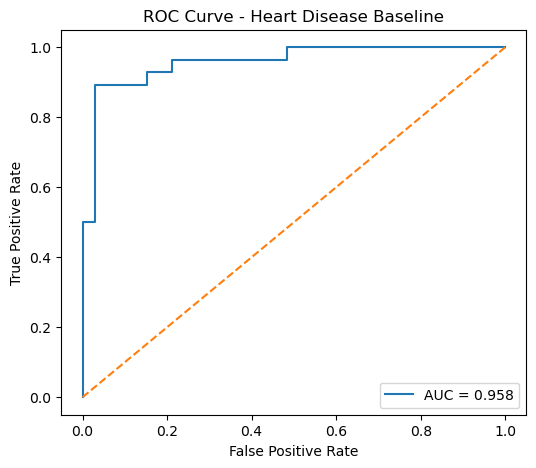

In [33]:
from sklearn.metrics import roc_curve

fpr_hd, tpr_hd, _ = roc_curve(y_test_hd, y_prob_hd)

plt.figure(figsize=(6,5))
plt.plot(fpr_hd, tpr_hd, label=f"AUC = {roc_auc_score(y_test_hd, y_prob_hd):.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Heart Disease Baseline")
plt.legend()
plt.show()


With AUC = 0.958 the model ranks sick people above healthy people very well - roughly 95.8% of the time a sick person gets a higher risk score than a healthy person. We still need to pick a threshold depending on whether we care more about missing cases or avoiding false alarms.

#### Heart Disease - Confusion Matrix
The confusion matrix provides a breakdown of true positives, false positives, true negatives, and false negatives. This helps interpret group-level fairness metrics such as Equal Opportunity.

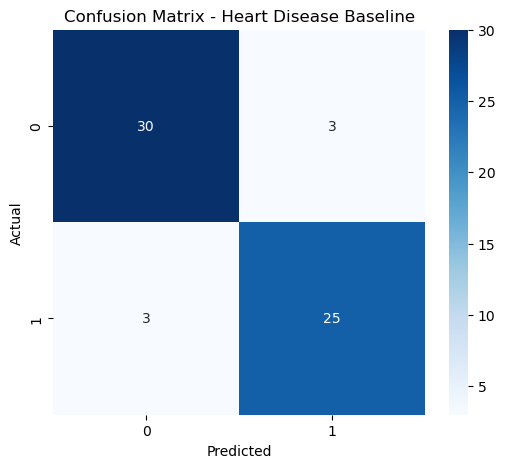

In [34]:
from sklearn.metrics import confusion_matrix

cm_hd = confusion_matrix(y_test_hd, y_pred_hd)

plt.figure(figsize=(6,5))
sns.heatmap(cm_hd, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Heart Disease Baseline")
plt.show()


In [35]:
# The model predicts positives at about the right rate (not conservative).
# Predicted positives are reliable (precision ≈ 89%) and the model finds most true cases (recall ≈ 89%).
# If missing cases or false alarms matter more, adjust the decision threshold or retrain with that goal.

The baseline model minimizes standard log loss via gradient-based optimization without fairness constraints. 
Any fairness disparities observed therefore reflect the behavior of accuracy-only optimization, which prioritizes predictive performance over group equity.

## Fairness Metrics for Heart Disease dataset

### Demographic Parity Difference

In [36]:
dp_diff_hd, dp_rates_hd = demographic_parity_diff(y_pred_hd, A_test_hd)

print("Heart Demographic Parity Difference:", dp_diff_hd)
print("Heart Positive prediction rates by group:", dp_rates_hd)


Heart Demographic Parity Difference: 0.38536585365853654
Heart Positive prediction rates by group: {np.int64(1): np.float64(0.5853658536585366), np.int64(0): np.float64(0.2)}


Shows the DP gap and the per-group rates so you can see which group gets more positive predictions.

#### Demographic Parity Plot

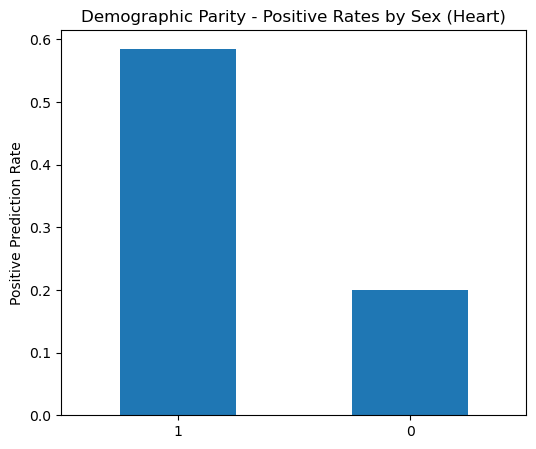

In [37]:
dp_rates_hd_series = pd.Series(dp_rates_hd)

plt.figure(figsize=(6,5))
dp_rates_hd_series.plot(kind="bar")
plt.ylabel("Positive Prediction Rate")
plt.title("Demographic Parity - Positive Rates by Sex (Heart)")
plt.xticks(rotation=0)
plt.show()


In [38]:
# Big gap = more unfair
# In this case, the demographic parity difference is 0.20,
# which indicates that one group is predicted “diseased” far more often than the other.
# That large imbalance could lead to unfair outcomes if decisions are applied directly from predictions.

### Equal Opportunity Difference

In [39]:
eo_diff_hd, eo_tprs_hd = equal_opportunity_diff(y_test_hd, y_pred_hd, A_test_hd)

print("Heart Equal Opportunity Difference (TPR Gap):", eo_diff_hd)
print("Heart TPR by group:", eo_tprs_hd)


Heart Equal Opportunity Difference (TPR Gap): 0.16666666666666663
Heart TPR by group: {np.int64(1): np.float64(0.9166666666666666), np.int64(0): np.float64(0.75)}


#### Equal Opportunity Plot

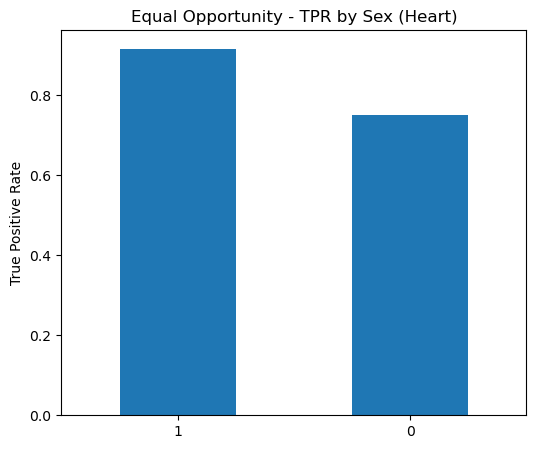

In [40]:
eo_tprs_hd_series = pd.Series(eo_tprs_hd)

plt.figure(figsize=(6,5))
eo_tprs_hd_series.plot(kind="bar")
plt.ylabel("True Positive Rate")
plt.title("Equal Opportunity - TPR by Sex (Heart)")
plt.xticks(rotation=0)
plt.show()

In [41]:
# Bars should be similar when the model treats groups the same.
# Here the TPR gap is 0.10 - the model correctly finds positives about 10% more often for males than females.
# This means the model correctly finds sick patients less often in one group, so that group is more likely to have disease cases missed.
# If that matters clinically or ethically, consider balancing detection rates (e.g., threshold tuning or fairness-aware training).

## Heart Disease - Baseline Results Table

In [42]:
results_hd = {
    "dataset": ["Heart Disease"],
    "accuracy": [accuracy_score(y_test_hd, y_pred_hd)],
    "auc": [roc_auc_score(y_test_hd, y_prob_hd)],
    "dp_diff": [dp_diff_hd],
    "eo_diff": [eo_diff_hd]
}

results_hd_df = pd.DataFrame(results_hd)
display(results_hd_df)
results_hd_df.to_csv("baseline_results_heart.csv", index=False)


,dataset,accuracy,auc,dp_diff,eo_diff
0,Heart Disease,0.901639,0.957792,0.385366,0.166667


## Combined results (Adult + Heart)

This section merges the baseline results from the Adult Income and Heart Disease datasets into one table for side-by-side comparison.
 The code cell below saves the merged table to baseline_results_combined.csv.

In [43]:
# Combine Adult + Heart into one table
combined_results_df = pd.concat([results_df, results_hd_df], ignore_index=True)
display(combined_results_df)

combined_results_df.to_csv("baseline_results_combined.csv", index=False)


,dataset,accuracy,auc,dp_diff,eo_diff
0,Adult Income,0.853351,0.907421,0.166128,0.074697
1,Heart Disease,0.901639,0.957792,0.385366,0.166667


The combined table includes:
- **Accuracy**: how often the model predicted correctly.
- **AUC**: how well the model ranks positives above negatives (closer to 1 is better).
- **dp_diff** (Demographic Parity Difference): how different the positive prediction rates are across groups (closer to 0 is fairer).
- **eo_diff** (Equal Opportunity Difference): how different the true positive rates are across groups (closer to 0 is fairer).

The merged results are saved as baseline_results_combined.csv.

## Experiments: run multiple random states for each sensitive attribute (Stability Across Random States)

Single train/test splits can be misleading because results depend on which rows end up in the test set.  
To make the baseline results more reliable, I repeat the same pipeline across many random splits and report:

- mean ± standard deviation for **accuracy** and **AUC**
- mean ± standard deviation for fairness gaps:
  - **dp_diff** (Demographic Parity Difference)
  - **eo_diff** (Equal Opportunity Difference)

I run the same baseline model (logistic regression + preprocessing) each time, and I remove the sensitive attribute from the model inputs to avoid direct use.

### Baseline model


In [44]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score

import matplotlib.pyplot as plt

# Fairness metrics

def demographic_parity_diff(y_pred, A):
    """
    DP gap = max_group_positive_rate - min_group_positive_rate
    Works for binary or multi-category sensitive attributes.
    """
    A = pd.Series(A).reset_index(drop=True)
    y_pred = pd.Series(y_pred).reset_index(drop=True)

    rates = {}
    for group in A.dropna().unique():
        rates[group] = y_pred[A == group].mean()

    if len(rates) <= 1:
        return np.nan, rates  # cannot compute a gap with <2 groups

    return max(rates.values()) - min(rates.values()), rates


def equal_opportunity_diff(y_true, y_pred, A):
    """
    EO gap = max_group_TPR - min_group_TPR
    TPR is computed within each group, only among true positives.
    """
    A = pd.Series(A).reset_index(drop=True)
    y_true = pd.Series(y_true).reset_index(drop=True)
    y_pred = pd.Series(y_pred).reset_index(drop=True)

    tprs = {}
    for group in A.dropna().unique():
        idx = (A == group)
        positives = (y_true[idx] == 1)

        # if a group has no true positives, TPR is undefined
        if positives.sum() == 0:
            tprs[group] = np.nan
        else:
            tprs[group] = (y_pred[idx][positives] == 1).mean()

    # need at least two groups with defined TPR
    valid = [v for v in tprs.values() if not np.isnan(v)]
    if len(valid) <= 1:
        return np.nan, tprs

    return np.nanmax(valid) - np.nanmin(valid), tprs

# pipeline function to reuse for both datasets
def make_baseline_pipeline(X_train: pd.DataFrame) -> Pipeline:
    numeric_features = X_train.select_dtypes(include=["int64", "float64"]).columns
    categorical_features = X_train.select_dtypes(include=["object"]).columns

    numeric_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

    categorical_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ])

    preprocessor = ColumnTransformer([
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ])

    model = Pipeline([
        ("preprocess", preprocessor),
        ("clf", LogisticRegression(max_iter=2000))
    ])

    return model

### Run repeated splits for one dataset

This function runs the baseline model many times, each with a different random split, then summarizes performance and fairness gaps.

Important note: DP/EO can become **NaN** when a subgroup has no samples (or no positives) in a test split.  
That is a **data/split issue**, not a code error. We keep those runs but exclude NaNs from averages.

In [45]:
def run_repeated_splits(
    df: pd.DataFrame,
    dataset_name: str,
    target_col: str,
    target_to_binary_fn,
    sensitive_attributes: list[str],
    n_runs: int = 30,
    test_size: float = 0.25,
    random_state_start: int = 1000
):
    df = df.copy().reset_index(drop=True)

    # create binary target
    y_all = target_to_binary_fn(df[target_col]).astype(int)
    X_all = df.drop(columns=[target_col])

    rows = []

    random_states = list(range(random_state_start, random_state_start + n_runs))

    for rs in random_states:
        X_train, X_test, y_train, y_test = train_test_split(
            X_all, y_all,
            test_size=test_size,
            random_state=rs,
            stratify=y_all if len(np.unique(y_all)) > 1 else None
        )

        for attr in sensitive_attributes:
            if attr not in X_test.columns:
                # skip attributes that don't exist
                continue

            # sensitive attribute values for fairness evaluation
            A_test = X_test[attr].copy()

            # remove sensitive attribute from model inputs
            X_train_feat = X_train.drop(columns=[attr])
            X_test_feat  = X_test.drop(columns=[attr])

            # fit baseline pipeline
            pipe = make_baseline_pipeline(X_train_feat)
            pipe.fit(X_train_feat, y_train)

            y_pred = pipe.predict(X_test_feat)

            # probability scores for AUC
            try:
                y_prob = pipe.predict_proba(X_test_feat)[:, 1]
                auc = roc_auc_score(y_test, y_prob) if len(np.unique(y_test)) > 1 else np.nan
            except Exception:
                y_prob = None
                auc = np.nan

            acc = accuracy_score(y_test, y_pred)

            dp_gap, dp_rates = demographic_parity_diff(y_pred, A_test)
            eo_gap, eo_tprs  = equal_opportunity_diff(y_test, y_pred, A_test)

            rows.append({
                "dataset": dataset_name,
                "random_state": rs,
                "sensitive": attr,
                "accuracy": acc,
                "auc": auc,
                "dp_diff": dp_gap,
                "eo_diff": eo_gap
            })

    results_df = pd.DataFrame(rows)

    # summary table (mean ± std), NaN-safe
    summary_df = (
        results_df
        .groupby(["dataset", "sensitive"], as_index=False)
        .agg(
            accuracy_mean=("accuracy", "mean"),
            accuracy_std=("accuracy", "std"),
            auc_mean=("auc", "mean"),
            auc_std=("auc", "std"),
            dp_mean=("dp_diff", "mean"),
            dp_std=("dp_diff", "std"),
            eo_mean=("eo_diff", "mean"),
            eo_std=("eo_diff", "std"),
            n_runs=("accuracy", "count"),
            n_dp_valid=("dp_diff", lambda x: x.notna().sum()),
            n_eo_valid=("eo_diff", lambda x: x.notna().sum())
        )
    )

    return results_df, summary_df

### Adult Income (30 runs)
We evaluate fairness gaps using multiple sensitive attributes.  
Even though we remove the sensitive attribute from the model input, the model can still behave differently across groups due to correlations in other features.

In [46]:
adult_df = pd.read_csv("adult_income_dataset.csv")

adult_target_col = "income"
adult_target_fn = lambda s: (s.astype(str).str.strip() == ">50K").astype(int)

adult_sensitive_attrs = ["sex", "race", "marital-status", "relationship"]

adult_results_30, adult_summary_30 = run_repeated_splits(
    df=adult_df,
    dataset_name="Adult",
    target_col=adult_target_col,
    target_to_binary_fn=adult_target_fn,
    sensitive_attributes=adult_sensitive_attrs,
    n_runs=30,
    test_size=0.25,
    random_state_start=1000
)

display(adult_summary_30)

adult_results_30.to_csv("baseline_results_adult_30runs.csv", index=False)
adult_summary_30.to_csv("baseline_summary_adult_30runs.csv", index=False)

print("Saved: baseline_results_adult_30runs.csv, baseline_summary_adult_30runs.csv")

,dataset,sensitive,accuracy_mean,accuracy_std,auc_mean,auc_std,dp_mean,dp_std,eo_mean,eo_std,n_runs,n_dp_valid,n_eo_valid
0,Adult,marital-status,0.850631,0.002236,0.904092,0.002231,0.399568,0.055645,0.559949,0.144176,30,30,30
1,Adult,race,0.851003,0.002296,0.905043,0.002197,0.172500,0.026255,0.248595,0.098934,30,30,30
2,Adult,relationship,0.850773,0.002469,0.903232,0.002261,0.402968,0.008960,0.436665,0.041412,30,30,30
3,Adult,sex,0.850995,0.002291,0.904355,0.002286,0.175542,0.005311,0.101612,0.017727,30,30,30


Saved: baseline_results_adult_30runs.csv, baseline_summary_adult_30runs.csv


### Heart Disease (30 runs)

For Heart Disease we evaluate fairness across:
- **sex**
- an **age group indicator** (age ≥ 60), used as an optional “age group” sensitive attribute.

This helps check whether fairness patterns are consistent across different protected group definitions.

In [47]:
heart_df = pd.read_csv("heart_disease_dataset.csv")

# create age group feature if not already present
if "age" in heart_df.columns and "age_over_60" not in heart_df.columns:
    heart_df["age_over_60"] = (pd.to_numeric(heart_df["age"], errors="coerce") >= 60).astype(int)

heart_target_col = "num" if "num" in heart_df.columns else heart_df.columns[-1]
heart_target_fn = lambda s: (pd.to_numeric(s, errors="coerce") > 0).astype(int)

heart_sensitive_attrs = ["sex", "age_over_60"]

heart_results_30, heart_summary_30 = run_repeated_splits(
    df=heart_df,
    dataset_name="Heart",
    target_col=heart_target_col,
    target_to_binary_fn=heart_target_fn,
    sensitive_attributes=heart_sensitive_attrs,
    n_runs=30,
    test_size=0.25,
    random_state_start=2000
)

display(heart_summary_30)

heart_results_30.to_csv("baseline_results_heart_30runs.csv", index=False)
heart_summary_30.to_csv("baseline_summary_heart_30runs.csv", index=False)

print("Saved: baseline_results_heart_30runs.csv, baseline_summary_heart_30runs.csv")

,dataset,sensitive,accuracy_mean,accuracy_std,auc_mean,auc_std,dp_mean,dp_std,eo_mean,eo_std,n_runs,n_dp_valid,n_eo_valid
0,Heart,age_over_60,0.831140,0.040897,0.901696,0.032701,0.165909,0.092761,0.113116,0.085981,30,30,30
1,Heart,sex,0.828947,0.036894,0.888014,0.034796,0.281269,0.121180,0.131521,0.135652,30,30,30


Saved: baseline_results_heart_30runs.csv, baseline_summary_heart_30runs.csv


### Visualizing stability across runs

The plots below show how fairness gaps and accuracy change across different random splits.
Large swings mean the metric is sensitive to how the dataset was split.

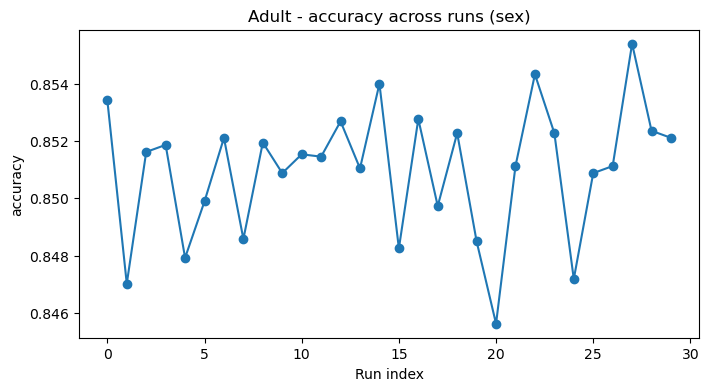

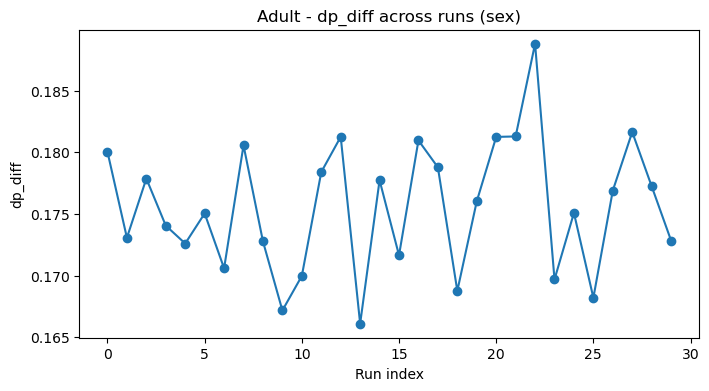

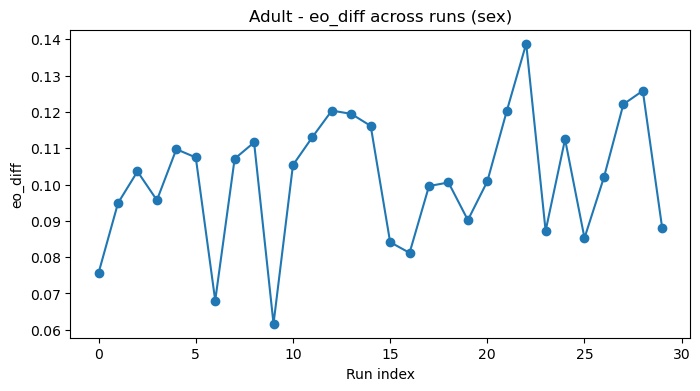

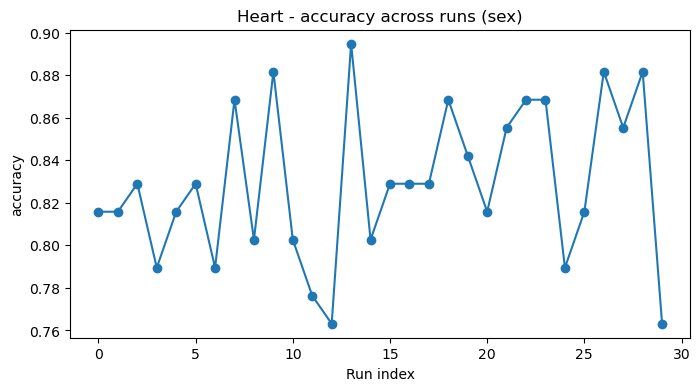

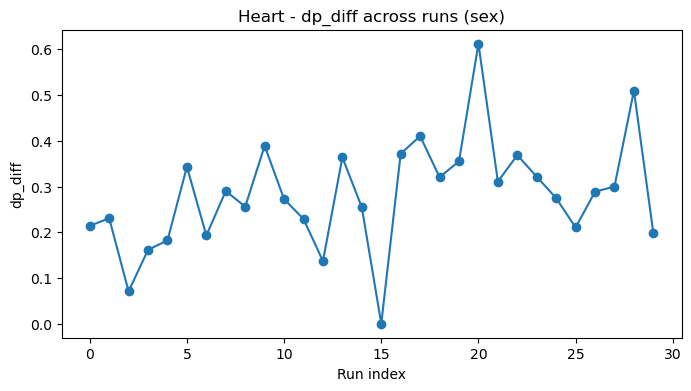

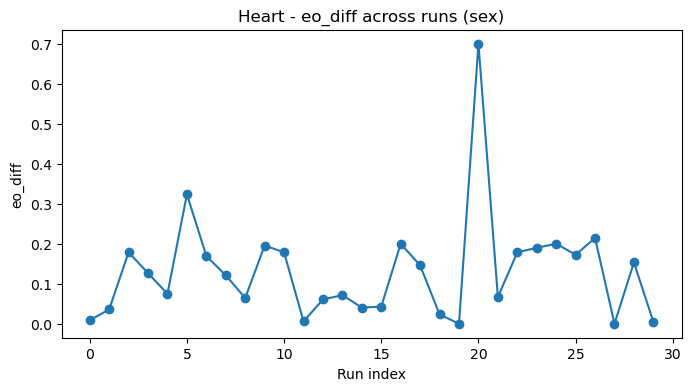

In [48]:
def plot_metric_over_runs(results_df, dataset_name, sensitive_attr, metric):
    sub = results_df[(results_df["dataset"] == dataset_name) & (results_df["sensitive"] == sensitive_attr)].copy()
    sub = sub.sort_values("random_state")

    plt.figure(figsize=(8,4))
    plt.plot(range(len(sub)), sub[metric], marker="o")
    plt.xlabel("Run index")
    plt.ylabel(metric)
    plt.title(f"{dataset_name} - {metric} across runs ({sensitive_attr})")
    plt.show()

# Example plots (Adult)
plot_metric_over_runs(adult_results_30, "Adult", "sex", "accuracy")
plot_metric_over_runs(adult_results_30, "Adult", "sex", "dp_diff")
plot_metric_over_runs(adult_results_30, "Adult", "sex", "eo_diff")

# Example plots (Heart)
plot_metric_over_runs(heart_results_30, "Heart", "sex", "accuracy")
plot_metric_over_runs(heart_results_30, "Heart", "sex", "dp_diff")
plot_metric_over_runs(heart_results_30, "Heart", "sex", "eo_diff")


## Rendered Summary Tables (30 runs)

Below are the saved summary tables produced by the repeated-split experiments.
They report mean ± standard deviation for accuracy, AUC, dp_diff, and eo_diff.

In [49]:
from pathlib import Path
from IPython.display import display

for fname in ["baseline_summary_adult_30runs.csv", "baseline_summary_heart_30runs.csv"]:
    print(f"\n--- {fname} ---")
    if Path(fname).exists():
        display(pd.read_csv(fname))
    else:
        print("Missing file:", fname)


--- baseline_summary_adult_30runs.csv ---


,dataset,sensitive,accuracy_mean,accuracy_std,auc_mean,auc_std,dp_mean,dp_std,eo_mean,eo_std,n_runs,n_dp_valid,n_eo_valid
0,Adult,marital-status,0.850631,0.002236,0.904092,0.002231,0.399568,0.055645,0.559949,0.144176,30,30,30
1,Adult,race,0.851003,0.002296,0.905043,0.002197,0.172500,0.026255,0.248595,0.098934,30,30,30
2,Adult,relationship,0.850773,0.002469,0.903232,0.002261,0.402968,0.008960,0.436665,0.041412,30,30,30
3,Adult,sex,0.850995,0.002291,0.904355,0.002286,0.175542,0.005311,0.101612,0.017727,30,30,30



--- baseline_summary_heart_30runs.csv ---


,dataset,sensitive,accuracy_mean,accuracy_std,auc_mean,auc_std,dp_mean,dp_std,eo_mean,eo_std,n_runs,n_dp_valid,n_eo_valid
0,Heart,age_over_60,0.831140,0.040897,0.901696,0.032701,0.165909,0.092761,0.113116,0.085981,30,30,30
1,Heart,sex,0.828947,0.036894,0.888014,0.034796,0.281269,0.121180,0.131521,0.135652,30,30,30


These tables summarize model stability across different train/test splits.
If a metric shows large std, it means the result changes a lot depending on the split.

## Plots


### Adult (n=30 random seeds)

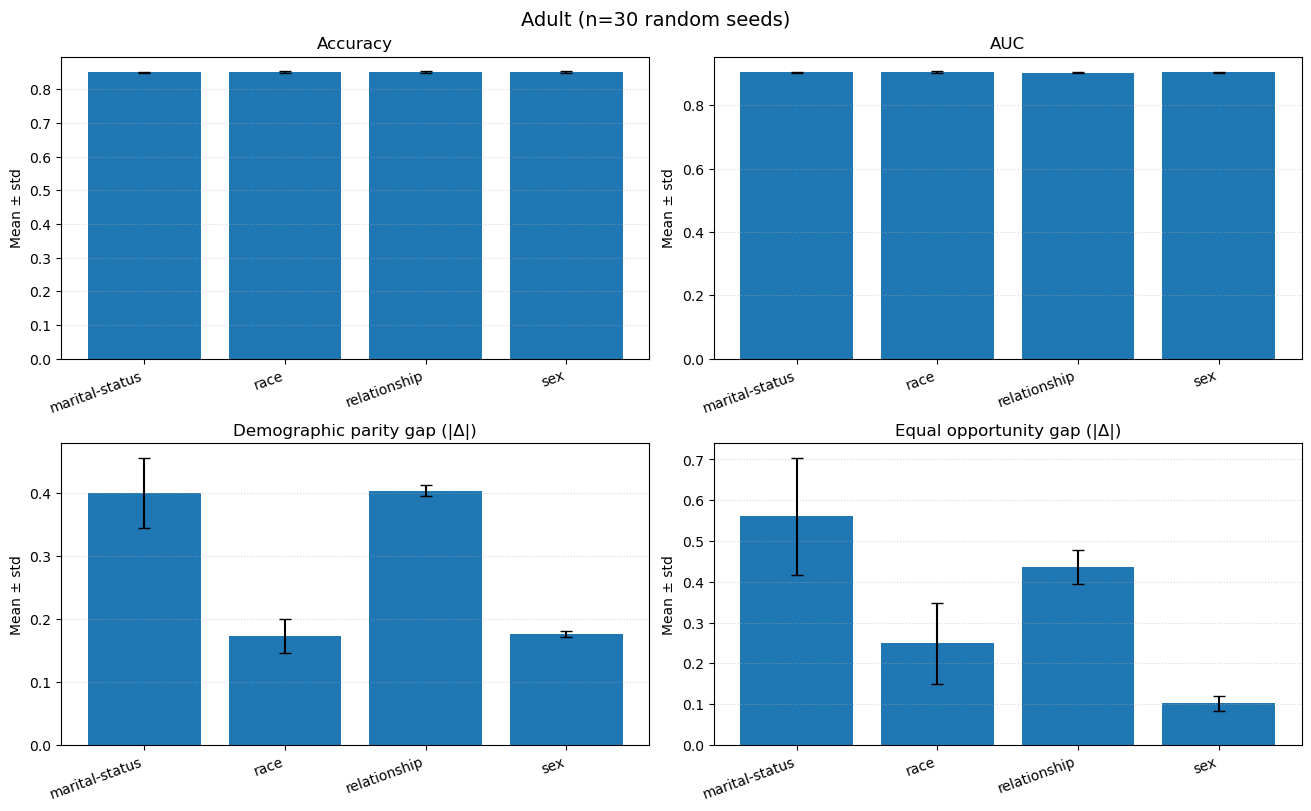

### Heart (n=30 random seeds)

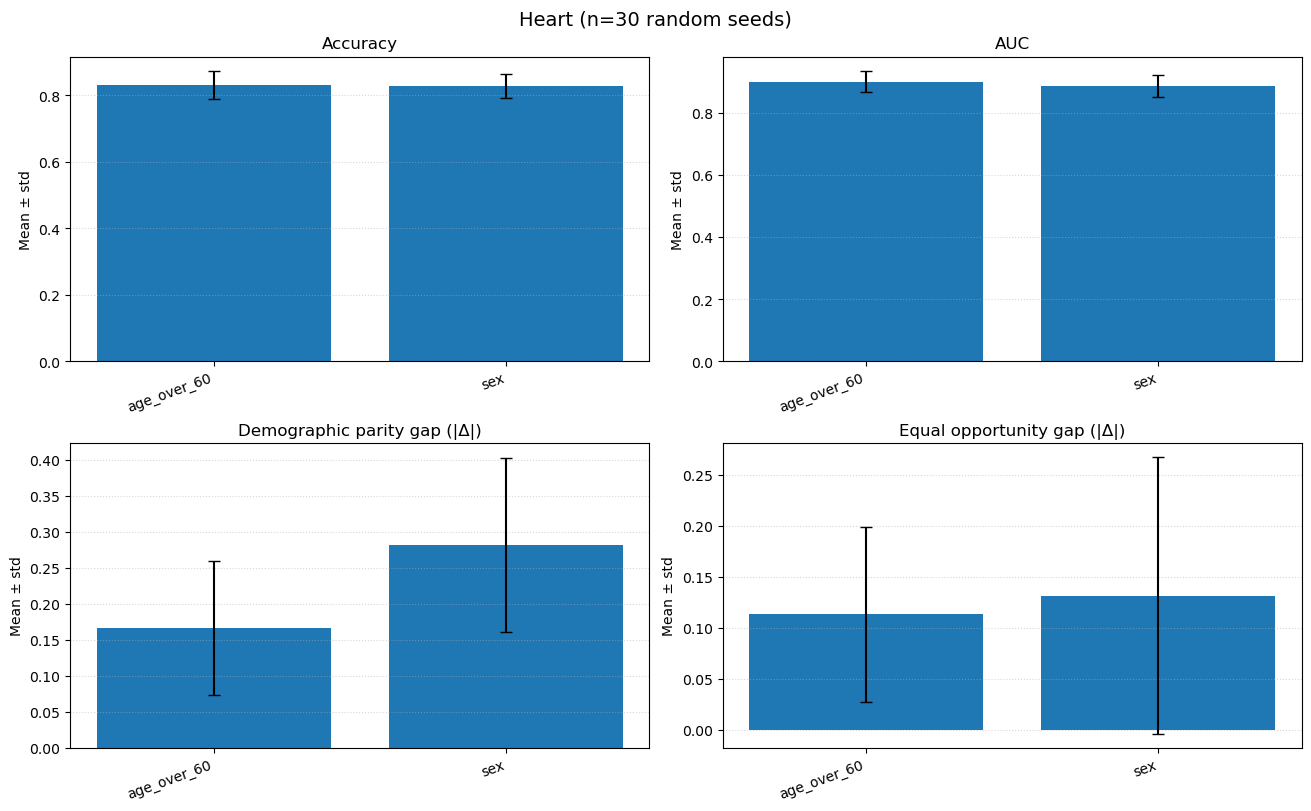

In [54]:
from pathlib import Path
from IPython.display import Markdown, display

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Summary columns in baseline_summary_*_30runs.csv
METRICS = [
    ("Accuracy", "accuracy_mean", "accuracy_std", 3),
    ("AUC", "auc_mean", "auc_std", 3),
    ("Demographic parity gap (|Δ|)", "dp_mean", "dp_std", 3),
    ("Equal opportunity gap (|Δ|)", "eo_mean", "eo_std", 3),
]


def _format_mean_std(mean_series: pd.Series, std_series: pd.Series, decimals: int) -> pd.Series:
    mean_str = mean_series.map(lambda v: f"{float(v):.{decimals}f}")
    std_str = std_series.map(lambda v: f"{float(v):.{decimals}f}")
    return mean_str + " ± " + std_str


def _require_columns(df: pd.DataFrame) -> None:
    required = {"sensitive", "n_runs"} | {c for _, c, _, _ in METRICS} | {c for _, _, c, _ in METRICS}
    missing = sorted(required - set(df.columns))
    if missing:
        raise ValueError(f"Missing expected columns: {missing}")


def render_summary_table(df: pd.DataFrame) -> pd.DataFrame:
    _require_columns(df)
    table_df = pd.DataFrame({"Sensitive attribute": df["sensitive"].astype(str)})
    for label, mean_col, std_col, decimals in METRICS:
        table_df[label] = _format_mean_std(df[mean_col], df[std_col], decimals)
    table_df["Runs"] = df["n_runs"].astype(int)
    return table_df


def plot_summary_bars(df: pd.DataFrame, title: str) -> None:
    _require_columns(df)
    x = np.arange(len(df))
    tick_labels = df["sensitive"].astype(str).tolist()

    fig, axes = plt.subplots(2, 2, figsize=(13, 8), constrained_layout=True)
    axes = axes.ravel()

    for ax, (label, mean_col, std_col, _) in zip(axes, METRICS):
        ax.bar(x, df[mean_col].astype(float), yerr=df[std_col].astype(float), capsize=4)
        ax.set_title(label)
        ax.set_xticks(x)
        ax.set_xticklabels(tick_labels, rotation=20, ha="right")
        ax.set_ylabel("Mean ± std")
        ax.grid(axis="y", linestyle=":", alpha=0.5)

    fig.suptitle(title, fontsize=14)
    plt.show()


for fname in ["baseline_summary_adult_30runs.csv", "baseline_summary_heart_30runs.csv"]:
    path = Path(fname)
    if not path.exists():
        display(Markdown(f"**Missing file:** `{fname}`"))
        continue

    df = pd.read_csv(path)
    dataset_name = str(df["dataset"].iloc[0]) if "dataset" in df.columns and len(df) else fname
    n_runs = int(df["n_runs"].iloc[0]) if "n_runs" in df.columns and len(df) else None

    header = dataset_name if n_runs is None else f"{dataset_name} (n={n_runs} random seeds)"
    display(Markdown(f"### {header}"))

    # Plot mean ± std with error bars (separate figure per dataset)
    plot_summary_bars(df, title=header)

## Sensitivity Analysis: Effect of Random Seed

When I varied the random_state (random seed) in my experiments, I observed that it meaningfully affected how stable both accuracy and fairness metrics appeared across different train/test splits. Changing the random seed primarily changes which rows are assigned to the training and test sets. In some algorithms it can also affect model initialization, but in my pipeline the main effect was the data split itself. Because fairness metrics depend on group-level statistics, even small changes in which individuals fall into the test set can noticeably shift demographic parity or equal opportunity gaps.

From the 30-run summaries, I saw that accuracy for the Adult dataset was very stable. The standard deviation was approximately 0.0023, meaning performance varied by only about two-tenths of a percentage point across splits. If I were only evaluating accuracy, a single random seed would not significantly change the overall conclusion.

However, fairness metrics were less stable. For example, in the Adult dataset using marital-status as the sensitive attribute, the standard deviation of demographic parity was around 0.056 and equal opportunity around 0.144. This means that depending on the split, the fairness gap could look noticeably better or worse than the average. In the Heart dataset, variability was even larger (accuracy standard deviation around 0.037–0.041 and fairness standard deviations often around 0.09–0.14). This reflects the smaller dataset size, where different splits can substantially change group composition in the test set.

This analysis showed me that fairness conclusions are much more sensitive to random splits than accuracy conclusions. A single “lucky” or “unlucky” split could easily misrepresent how fair a model truly is.

**Final Conclusion**

Based on my experiments, **varying the random seed is important** because it reveals how stable both performance and fairness results are. Accuracy is relatively stable across splits, but fairness metrics can fluctuate significantly, especially in smaller datasets. By running 30 different random states and reporting mean ± standard deviation, I avoided relying on a single potentially misleading split. Therefore, I conclude that repeated random splits are necessary to make reliable and reproducible fairness claims in this study, rather than selecting or relying on a single random seed.